## Company Profiling and Data Validation Task


This project cleanses, enriches, and validates company contact information using the Companies House API.
The final output includes matched and validated company names, addresses, postal codes, and county/locality.
Simple reporting and visualizations were added to summarize results.


In [18]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import re

## 1. Data Loading and Initial Profiling

In [2]:
# Load the dataset
# Display the first few rows to understand the data
df = pd.read_csv('Company.csv')
df.head(5)

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19/12/2024,NaN
1,BULLDOG LIMITED,09043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30/05/2025,16/05/2024
2,BULLDOG MUSHROOMS LTD,08465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/04/2025,28/03/2024
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/01/2025,18/12/2023
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/02/2022,25/01/2021


In [3]:
# Basic information about the dataset
df.info()


# print dataset number of rows and column
print('This dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CompanyName                         307 non-null    object 
 1    CompanyNumber                      306 non-null    object 
 2   RegAddress.CareOf                   2 non-null      object 
 3   RegAddress.POBox                    5 non-null      object 
 4   RegAddress.AddressLine1             307 non-null    object 
 5    RegAddress.AddressLine2            191 non-null    object 
 6   RegAddress.PostTown                 254 non-null    object 
 7   RegAddress.County                   108 non-null    object 
 8   RegAddress.Country                  248 non-null    object 
 9   RegAddress.PostCode                 304 non-null    object 
 10  CompanyCategory                     306 non-null    object 
 11  CompanyStatus                       306 non-n

In [4]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
CompanyName                             0
 CompanyNumber                          1
RegAddress.CareOf                     305
RegAddress.POBox                      302
RegAddress.AddressLine1                 0
 RegAddress.AddressLine2              116
RegAddress.PostTown                    53
RegAddress.County                     199
RegAddress.Country                     59
RegAddress.PostCode                     3
CompanyCategory                         1
CompanyStatus                           1
CountryOfOrigin                         2
DissolutionDate                       305
IncorporationDate                       2
Accounts.AccountRefDay                  6
Accounts.AccountRefMonth                5
Accounts.NextDueDate                    7
Accounts.LastMadeUpDate                85
Accounts.AccountCategory                1
Returns.NextDueDate                     8
Returns.LastMadeUpDate                206
Mortgages.NumMortCharges                2
Mortga

- Loaded `Company.csv` into a pandas DataFrame for initial exploration

- Reviewed basic information such as missing values, column data types, and shape. 

## 2. Data Cleaning

In [5]:
# Trim spaces from column names
df.columns = df.columns.str.strip()

# Strip leading/trailing spaces from object-type text fields
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].str.strip()


In [6]:
# Handling Misaligned Record

# Get the row as a Series
row = df.iloc[11]

# Shift the values 6 positions to the right
shifted_row = row.shift(periods=6)

# Replace the original row with the shifted row
df.iloc[11] = shifted_row

# Fill company number from URI Link
df.at[11, 'CompanyNumber'] = '01477370'

# Confirm the changes
#print(df.iloc[11])


In [7]:
# Remove columns with too many missing values (benchmark: more than 90% missing)

benchmark = 0.9
missing_ratio = df.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > benchmark].index
df_cleaned = df.drop(columns=columns_to_drop)

print(f"Columns dropped due to high missing ratio: {list(columns_to_drop)}")

Columns dropped due to high missing ratio: ['RegAddress.CareOf', 'RegAddress.POBox', 'DissolutionDate', 'SICCode.SicText_3', 'SICCode.SicText_4', 'PreviousName_1.CONDATE', 'PreviousName_1.CompanyName', 'PreviousName_2.CONDATE', 'PreviousName_2.CompanyName', 'PreviousName_3.CONDATE', 'PreviousName_3.CompanyName', 'PreviousName_4.CONDATE', 'PreviousName_4.CompanyName', 'PreviousName_5.CONDATE', 'PreviousName_5.CompanyName', 'PreviousName_6.CONDATE', 'PreviousName_6.CompanyName', 'PreviousName_7.CONDATE', 'PreviousName_7.CompanyName', 'PreviousName_8.CONDATE', 'PreviousName_8.CompanyName', 'PreviousName_9.CONDATE', 'PreviousName_9.CompanyName', 'PreviousName_10.CONDATE', 'PreviousName_10.CompanyName']


In [8]:
# Convert appropriate fields to datetime (specifying DD/MM/YYYY format)
date_cols = ['IncorporationDate', 'Accounts.NextDueDate', 'Accounts.LastMadeUpDate', 
             'Returns.NextDueDate', 'Returns.LastMadeUpDate', 
             'ConfStmtNextDueDate', 'ConfStmtLastMadeUpDate']

for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], format='%d/%m/%Y', errors='coerce')


In [9]:
def clean_column_name(col):
    # Remove schema prefixes (e.g., 'RegAddress.')
    col = col.split('.')[-1]
    # Convert to snake_case
    col = re.sub(r'(?<=[a-z])(?=[A-Z0-9])|(?<=[A-Z])(?=[A-Z][a-z])', '_', col).lower()
    return col

# Apply function to dataframe
df_cleaned.columns = [clean_column_name(col) for col in df_cleaned.columns]

In [10]:
# Standardize both country and country_of_origin fields

# Defining a mapping for country name standardization
country_mapping = {
    'UK': 'United Kingdom',
    'ENGLAND': 'United Kingdom',
    'england': 'United Kingdom',
    'SCOTLAND': 'United Kingdom',
    'WALES': 'United Kingdom',
    'NORTHERN IRELAND': 'United Kingdom'
    
}


# Mapping to country if it exists
if 'country' in df_cleaned.columns:
    df_cleaned['country'] = df_cleaned['country'].replace(country_mapping)
    
df_cleaned['country'] = df_cleaned['country'].fillna('United Kingdom')

# Mapping to country_of_origin if it exists
if 'country_of_origin' in df_cleaned.columns:
    df_cleaned['country_of_origin'] = df_cleaned['country_of_origin'].replace(country_mapping)


In [11]:
# Converting some columns to title case
def conditional_title(x):
    if isinstance(x, str):
        return x.title()
    return x

columns_to_title = [col for col in df_cleaned.columns if col not in ['post_code', 'company_name', 'uri']]

for col in columns_to_title:
    df_cleaned[col] = df_cleaned[col].apply(conditional_title)


# Define columns to convert to uppercase
uppercase_cols = ['post_code', 'company_name', 'company_number']

# Converting specified columns to uppercase
df_cleaned[uppercase_cols] = df_cleaned[uppercase_cols].apply(lambda col: col.str.upper())


In [12]:
# Deduplication

# 1. Check if 'company_number' has any missing values
missing_company_numbers = df_cleaned['company_number'].isnull().sum()
print(f"Missing Company Numbers: {missing_company_numbers}")

# 2. Identify duplicate Company Numbers
duplicates = df_cleaned.duplicated(subset='company_number', keep=False)
print(f"\nNumber of Potential Duplicate Records based on company number: {duplicates.sum()}")


# 4. Drop duplicates, keeping the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset='company_number', keep='first')

print(f"\nDataset shape after removing duplicates: {df_cleaned.shape}")


Missing Company Numbers: 0

Number of Potential Duplicate Records based on company number: 34

Dataset shape after removing duplicates: (290, 30)


- Columns with a high percentage of missing values (over 90%) were dropped

- Record at index 11 was found to have a misalignment (each value were shifted 6 positions right)

- Identified potential duplicate records based on `company_number`. Duplicates were reviewed, and only the first occurrence was retained.



## 3. API INTEGRATION

In [13]:

# Companies House API key
API_KEY = '614c43c4-f999-453e-b07d-3652f55ebf63'

def query_companies_house_by_number(company_number):
    try:
        if pd.isnull(company_number):
            return {
                'api_match_found': False,
                'api_company_number': '',
                'api_company_status': '',
                'api_incorporation_date': '',
                'api_title': '',
                'api_address_line_1': '',
                'api_address_line_2': '',
                'api_postal_code': '',
                'api_locality': '',
                'api_country': ''
            }
        
        # Call Company Profile API directly
        profile_response = requests.get(
            f'https://api.company-information.service.gov.uk/company/{company_number}',
            auth=(API_KEY, '')
        )
        
        if profile_response.status_code == 404:
            print(f"Company {company_number} not found. (404)")
            return {
                'api_match_found': False,
                'api_company_number': company_number,
                'api_company_status': '',
                'api_incorporation_date': '',
                'api_company_name': '',
                'api_address_line_1': '',
                'api_address_line_2': '',
                'api_postal_code': '',
                'api_locality': '',
                'api_country': ''
            }
        
        profile_response.raise_for_status()
        profile_data = profile_response.json()
        
        registered_address = profile_data.get('registered_office_address', {})
        
        return {
            'api_match_found': True,
            'api_company_number': company_number,
            'api_company_status': profile_data.get('company_status', ''),
            'api_incorporation_date': profile_data.get('date_of_creation', ''),
            'api_company_name': profile_data.get('company_name', ''),
            'api_address_line_1': registered_address.get('address_line_1', ''),
            'api_address_line_2': registered_address.get('address_line_2', ''),
            'api_postal_code': registered_address.get('postal_code', ''),
            'api_locality': registered_address.get('locality', ''),
            'api_country': registered_address.get('country', '')
        }
    
    except Exception as e:
        print(f"Error querying {company_number}: {e}")
        return {
            'api_match_found': False,
            'api_company_number': company_number,
            'api_company_status': '',
            'api_incorporation_date': '',
            'api_company_name': '',
            'api_address_line_1': '',
            'api_address_line_2': '',
            'api_postal_code': '',
            'api_locality': '',
            'api_country': ''
        }


In [14]:
# Apply the updated function using company_number column
api_results = df_cleaned['company_number'].apply(query_companies_house_by_number)

# Convert to DataFrame
api_results_df = pd.json_normalize(api_results)

Company 05883574 not found. (404)


In [15]:
# Merge back with cleaned dataset
df_final = pd.concat([df_cleaned.reset_index(drop=True), api_results_df.reset_index(drop=True)], axis=1)

# Replace blank strings, whitespace-only, and placeholders with real NaN
df_final = df_final.replace(r'^\s*$', pd.NA, regex=True)  # empty or whitespace

#Rename county column to match source data naming
df_final = df_final.rename(columns={'county': 'locality'})


# Display result
df_final.head()

,company_name,company_number,address_line_1,address_line_2,post_town,locality,country,post_code,company_category,company_status,...,api_match_found,api_company_number,api_company_status,api_incorporation_date,api_company_name,api_address_line_1,api_address_line_2,api_postal_code,api_locality,api_country
0,BULLDOG MINI SKIPS LTD,15330909,"Yard 1, Arnock Bungalow",Southend Arterial Road,Brentwood,NaN,United Kingdom,CM13 3TB,Private Limited Company,Active,...,True,15330909,active,2023-12-06,BULLDOG MINI SKIPS LTD,"Yard 1, Arnock Bungalow",Southend Arterial Road,CM13 3TB,Brentwood,United Kingdom
1,BULLDOG LIMITED,09043007,Foresters Cottage,Stoney Heath,Basingstoke,Hampshire,United Kingdom,RG26 5SW,Private Limited Company,Active,...,True,09043007,active,2014-05-16,BULLDOG MORTLAKE LIMITED,Foresters Cottage,Stoney Heath,RG26 5SW,Basingstoke,<NA>
2,BULLDOG MUSHROOMS LTD,08465312,C58-59 New Covent Garden Market,Nine Elms Lane,NaN,NaN,United Kingdom,SW8 5JJ,Private Limited Company,Active,...,True,08465312,active,2013-03-28,BULLDOG MUSHROOMS LTD,C58-59 New Covent Garden Market,Nine Elms Lane,SW8 5JJ,London,<NA>
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,5 Ravensfield Gardens,Stoneleigh,Surrey,NaN,United Kingdom,KT19 0ST,Private Limited Company,Active,...,True,01652098,active,1982-07-16,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,5 Ravensfield Gardens,Stoneleigh,KT19 0ST,Surrey,<NA>
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,Southampton,NaN,United Kingdom,SO15 2RP,Private Limited Company,Liquidation,...,True,04667818,dissolved,2003-02-17,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,SO15 2RP,Southampton,<NA>


- Utilized direct Company Number lookups via the Companies House API. This provides faster, more accurate enrichment of contact and company information.

- Merges selected fields from the original company records and matched Companies House API results. 

- Key fields include both the original and validated company names, numbers, and detailed registered address.


## 4. Contact Information Matching and Validation

In [16]:
from difflib import SequenceMatcher

# Function to calculate similarity between two strings
def field_similarity(a, b):
    if pd.isnull(a) or pd.isnull(b):
        return 0
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

# Function to do exact match (for things like company number, postcode)
def exact_match(a, b):
    if pd.isnull(a) or pd.isnull(b):
        return False
    return str(a).strip().lower() == str(b).strip().lower()

# Validate fields
df_final['is_name_match'] = df_final.apply(lambda row: field_similarity(row['company_name'], row['api_company_name']) , axis=1)
df_final['is_number_match'] = df_final.apply(lambda row: exact_match(row['company_number'], row['api_company_number']), axis=1)
df_final['is_address1_match'] = df_final.apply(lambda row: field_similarity(row['address_line_1'], row['api_address_line_1']) , axis=1)
df_final['is_address2_match'] = df_final.apply(lambda row: field_similarity(row['address_line_2'], row['api_address_line_2']) , axis=1)
df_final['is_country_match'] = df_final.apply(lambda row: exact_match(row['country'], row['api_country']), axis=1)
df_final['is_county_match'] = df_final.apply(lambda row: exact_match(row['locality'], row['api_locality']), axis=1)
df_final['is_postcode_match'] = df_final.apply(lambda row: exact_match(row['post_code'], row['api_postal_code']), axis=1)

# Quick Summary
total_records = df_final.shape[0]

summary = {
    'Company Name Match Rate': round(df_final['is_name_match'].mean() * 100, 2),
    'Company Number Match Rate': round(df_final['is_number_match'].mean() * 100, 2),
    'Address Line 1 Match Rate': round(df_final['is_address1_match'].mean() * 100, 2),
    'Address Line 2 Match Rate': round(df_final['is_address2_match'].mean() * 100, 2),
    'County Match Rate': round(df_final['is_county_match'].mean() * 100, 2),
    'Country Match Rate': round(df_final['is_country_match'].mean() * 100, 2),
    'Postcode Match Rate': round(df_final['is_postcode_match'].mean() * 100, 2)
}

print("\nField Matching Summary:")
for key, value in summary.items():
    print(f"- {key}: {value}%")



Field Matching Summary:
- Company Name Match Rate: 96.6%
- Company Number Match Rate: 100.0%
- Address Line 1 Match Rate: 88.57%
- Address Line 2 Match Rate: 54.7%
- County Match Rate: 0.34%
- Country Match Rate: 27.59%
- Postcode Match Rate: 84.83%


- Validated individual field against API-enriched data using either exact matching or fuzzy similarity checks.  
-  Calculated match rate percentage for company name, number, address fields, county/locality, and postcode.


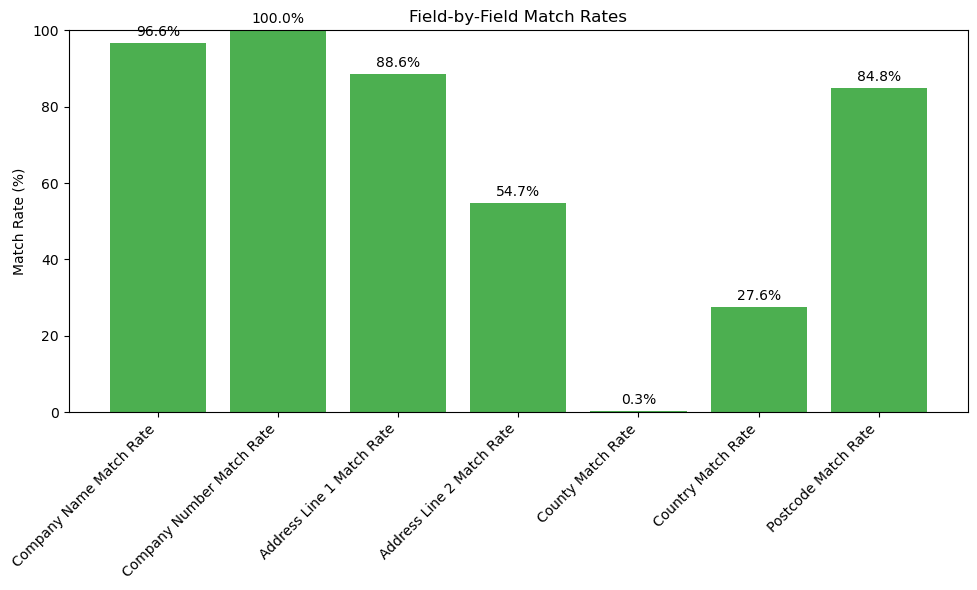

In [19]:

# Prepare data for the plot
fields = list(summary.keys())
match_rates = list(summary.values())

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(fields, match_rates, color='#4CAF50')
plt.ylabel('Match Rate (%)')
plt.title('Field-by-Field Match Rates')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()



The above bar chart shows the percentage of records where each field (company name, number, address, county, country, postal code) matched successfully between the original dataset and the Companies House API data.


## 5. Data Enrichment

In [20]:
# Data Enrichment (API values prioritized)

# Create a new DataFrame for final enriched records
final_enriched = pd.DataFrame()

# Define the mapping between original and API fields
record_mappings = {
    'company_name': 'api_company_name',
    'company_number': 'api_company_number',
    'address_line_1': 'api_address_line_1',
    'address_line_2': 'api_address_line_2',
    'post_code': 'api_postal_code',
    'locality': 'api_locality',
    'country': 'country'
}

# Fill each final column: use API if available, else original
for original_record, api_record in record_mappings.items():
    final_enriched[original_record] = df_final[api_record].combine_first(df_final[original_record])
                                       

# Drop  company_number = '05883574' as the company number was not found
final_enriched = final_enriched[final_enriched['company_number'] != '05883574']

# Sort alphabetically by 'company_name'
final_enriched = final_enriched.sort_values(by='company_name').reset_index(drop=True)

# Preview
print("\nFinal Enriched Dataset:")
final_enriched.head(10)



Final Enriched Dataset:


,company_name,company_number,address_line_1,address_line_2,post_code,locality,country
0,360 LAB LTD,14869093,Flat 5 61a Kirgate House,NaN,BD1 1PZ,Bradford,United Kingdom
1,AIRLINE RESERVATION LIMITED,14498022,85 Great Portland Street,NaN,W1W 7LT,London,United Kingdom
2,AIRLINE ROTABLES (UK HOLDINGS) LIMITED,02637160,2 Minton Place,Victoria Road,OX26 6QB,Bicester,United Kingdom
3,AIRLINE SERVICES AND COMPONENTS GROUP LIMITED,07652548,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,B3 2JR,Birmingham,United Kingdom
4,AIRLINE SERVICES COMPONENTS LIMITED,01503647,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,B3 2JR,Birmingham,United Kingdom
5,AIRLINE SERVICES HOLDINGS LIMITED,05211996,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rultan...,148 Edmund Street,B3 2JR,Birmingham,United Kingdom
6,AIRLINE SERVICES LIMITED,01685094,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,B3 2JR,Birmingham,United Kingdom
7,AIRLINE SERVICES TECHNICS LIMITED,06721205,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,B3 2JR,Birmingham,United Kingdom
8,AIRLINE SUPPORT LIMITED,15070430,86-90 Paul Street,NaN,EC2A 4NE,London,United Kingdom
9,AIRLINE TARIFF PUBLISHING COMPANY,FC014373,2340 Dulles Corner Blvd Suite 800,NaN,NaN,Herndon,United States


Each contact information field was enriched by prioritizing Companies House API data.  If no API data was available for a field, the original Company.csv value was used as fallback.

- A specific record with `company_number = 05883574` was removed as its not a registered company number.
- The final dataset was sorted alphabetically by company name.

In [21]:
# Check for missing values
print("\nMissing Values per Column:")
print(final_enriched.isnull().sum())


Missing Values per Column:
company_name        0
company_number      0
address_line_1      0
address_line_2    100
post_code           2
locality            2
country             0
dtype: int64


## 6. Export Enriched Dataset

In [22]:
# Save final matched contact information to CSV
final_enriched.to_csv('final_enriched.csv', index=False)

# 7. Conclusion

In this project, a complete data enrichment and validation pipeline was developed for UK company records.  The solution performed data cleaning, API-based enrichment using Companies House, and field-by-field validation for company name, number, address, and postcode.  

All enrichment prioritized API data with fallbacks to original values, ensuring accuracy and completeness.  The final enriched dataset is sorted, cleaned, and exported — ready for business use or downstream analytics.

This project demonstrates a scalable, API-driven data engineering workflow.
